In the Data folder file I showed that t>20 basically corresponds to noise. Here I want to check if the network performance improves if I throw out this noise.

In [1]:
import os
import sys

sys.path.append('../scripts')
sys.path.append('../models')

os.environ["CUDA_VISIBLE_DEVICES"]= '0' #, this way I would choose GPU 3 to do the work

import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom # for compressing images / only for testing purposes to speed up NN training
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torch.nn as nn
from data_preparation import *
from data_undersampling import *
from output_statistics import *

from interlacer_layer_modified import *
from Residual_Interlacer_modified import *
from skimage.metrics import structural_similarity as ssim 

grouped_time_steps = 1 # Set how many subsequent time steps you want to give to the network at once. Values allowed: 1, 2, 4, 8 (because it has to divide 8)

## **Estimating Best Possible Values of PSNR, SSIM, and MSE a Network Can Achieve at the Noise Level in the Ground Truth**


- **ground_truth = measured_full_rank_data** *(first 30 FID time steps)*
- **noise_equivalent_ground_truth = ground_truth + noise**
- **noise = measured_full_rank_data** *(last 30 FID time steps)*

Important: **ground_truth and noise_equivalent_ground_truth contain the same amount of physical information**, either of them could have been measured with equal chance, non is "truer" than the other.

Hence, the optimal achievable results a network can hope to achieve are

- **PSNR = PSNR(ground_truth,noise_equivalent_ground_truth)**
- **SSIM = SSIM(ground_truth,noise_equivalent_ground_truth)**
- **MSE = MSE(ground_truth,noise_equivalent_ground_truth)**

If your network is outperforming these thresholds, it is overfitting noise.

Select dataset

In [2]:
trancuate_t = 30
AF = 3

### Load data and tracuate
Ground_Truth = np.load('../data/Full_Rank_All_trancuated_k_space_masked.npy')
ground_truth_trancuated = Ground_Truth[:,:,:,:trancuate_t,:,:]

### Load undersampled data and trancuate
Undersampled_Data = np.load(f'../data/Undersampled_Data_P03-P08/Undersampled_possoin_3D_fixed_r0_AF_{AF}.npy')
Undersampled_Data_trancuated = Undersampled_Data[:,:,:,:trancuate_t,:,:]

#### extract noise, add it to ground truth to create noise equivalent ground truth
noise = Ground_Truth[:,:,:,96-trancuate_t:,:,:]
ground_truth_trancuated_2 = ground_truth_trancuated + noise

In [3]:
Ground_Truth.shape

(22, 22, 21, 96, 8, 6)

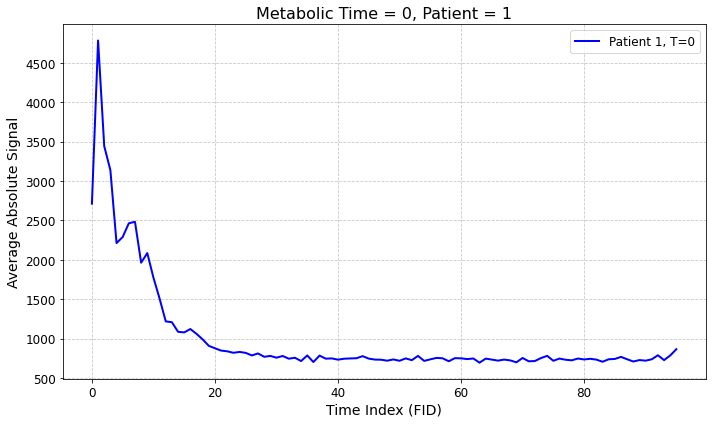

In [4]:
T = 0          # Metabolic time index
Patient = 1    # Patient index

Ground_Truth_abs = np.abs(Ground_Truth)
Patient_Set = Ground_Truth_abs[..., T, Patient]
Signal = []
for i in range(96):
    current_slice = Patient_Set[:, :, :, i]
    mean_signal = np.mean(current_slice)
    Signal.append(mean_signal)
Signal = np.array(Signal)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(96), Signal, color='blue', linewidth=2, label=f"Patient {Patient}, T={T}")
ax.set_xlabel("Time Index (FID)", fontsize=14)
ax.set_ylabel("Average Absolute Signal", fontsize=14)
ax.set_title(f"Metabolic Time = {T}, Patient = {Patient}", fontsize=16)
ax.legend(fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.show()

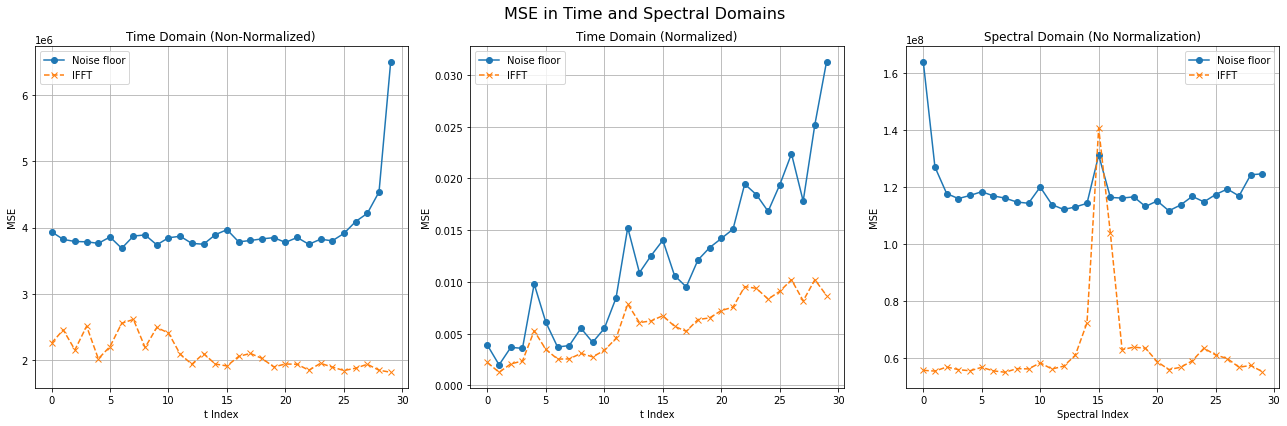

==== Model Output vs Ground Truth ====
Total MSE in image domain: 1978863.3114839261
Normalized Total MSE in image domain: 0.005977655694632373
Total MSE in spectral domain: 59365899.344517775

==== Model Input vs Ground Truth ====
Total MSE in image domain: 1043441.2700121696
Normalized Total MSE in image domain: 0.0029128035925264925
Total MSE in spectral domain: 31303238.100365084


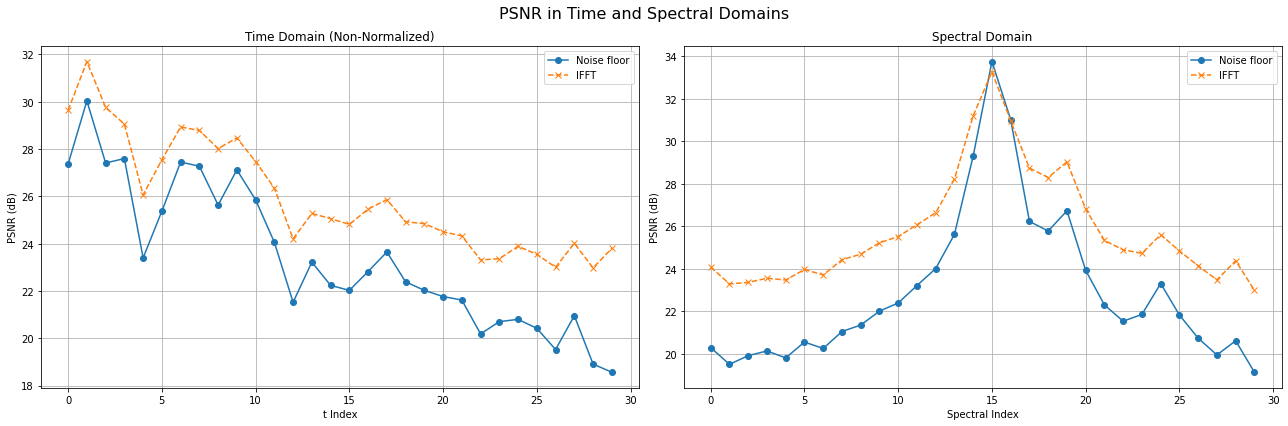

==== Model Output vs. Ground Truth ====
Average PSNR in image domain:    23.391987553295724
Average PSNR in frequency domain: 22.93057646269399

==== Model Input vs. Ground Truth ====
Average PSNR in image domain:    25.960191933324133
Average PSNR in frequency domain: 25.82490367226175


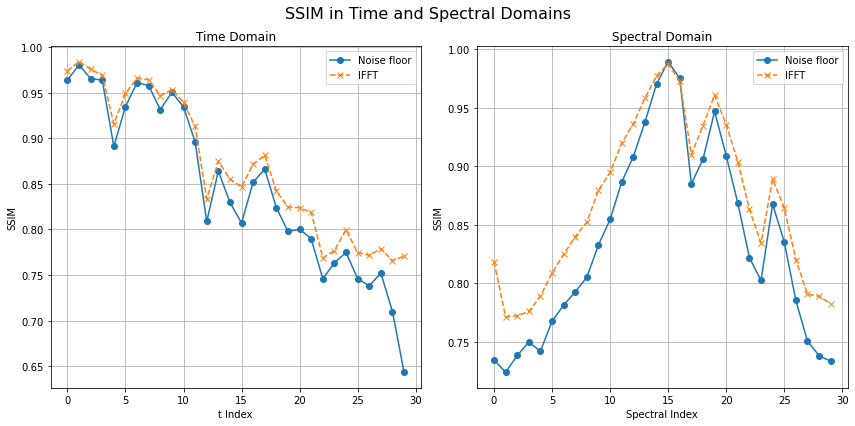

==== Model Output vs. Ground Truth ====
Average SSIM in image domain:    0.8481743369498033
Average SSIM in frequency domain: 0.8347511472507282

==== Model Input vs. Ground Truth ====
Average SSIM in image domain:    0.8710835255629995
Average SSIM in frequency domain: 0.8686405658745238


In [5]:
Patient = 1
label = "Noise floor"

_, _, norm_values_test = normalize_data_per_image_new(ground_truth_trancuated[..., Patient], Undersampled_Data_trancuated[..., Patient])

plot_general_statistics(ground_truth_trancuated_2[...,Patient], Undersampled_Data_trancuated[...,Patient], ground_truth_trancuated[...,Patient], trancuate_t, norm_values_test, label)
plot_general_statistics_PSNR(ground_truth_trancuated_2[...,Patient], Undersampled_Data_trancuated[...,Patient], ground_truth_trancuated[...,Patient], trancuate_t, norm_values_test, label)
plot_general_statistics_SSIM(ground_truth_trancuated_2[...,Patient], Undersampled_Data_trancuated[...,Patient], ground_truth_trancuated[...,Patient], trancuate_t, norm_values_test, label)

Optimal statistics

/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)
../scripts/output_statistics.py:279: RuntimeWarning: invalid value encountered in double_scalars
  return calculate_rmse(pred, gt) / (gt.max() - gt.min())


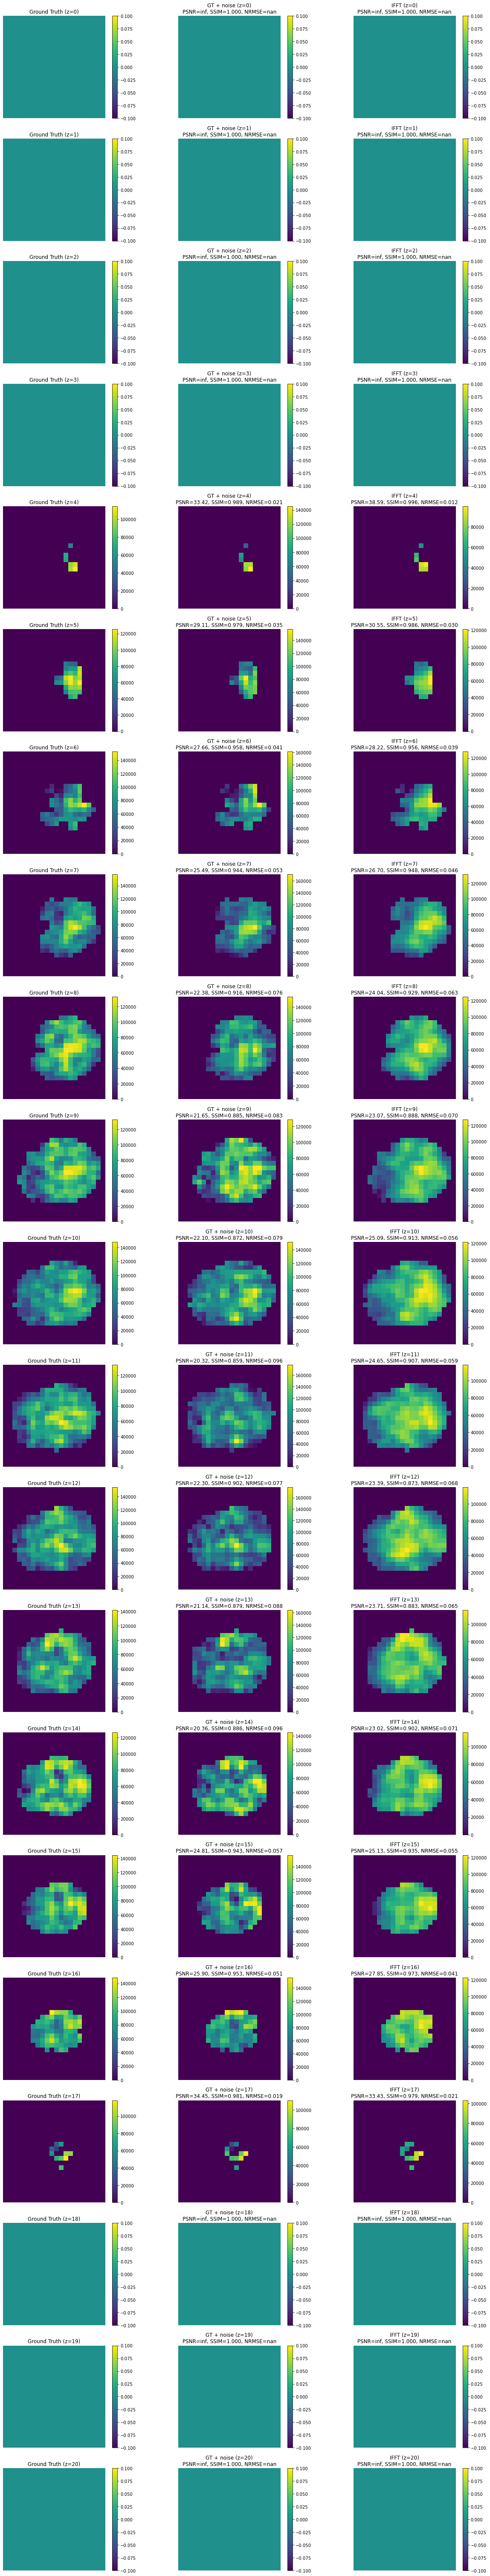

In [6]:
Patient = 4
label = "GT + noise"

t = 18
T = 7

comparison_Plot_3D_vs_Ifft(ground_truth_trancuated_2[...,Patient], ground_truth_trancuated[...,Patient], Undersampled_Data_trancuated[...,Patient], t, T, domain="spectral", label = label)

# **Regular Undersampling**

In [7]:
trancuate_t = 30

### Load data and tracuate
Ground_Truth = np.load('../data/Full_Rank_All_trancuated_k_space_masked.npy')
ground_truth_trancuated = Ground_Truth[:,:,:,:trancuate_t,:,:]

### Load undersampled data and trancuate
Undersampled_Data = np.load(f'../data/Undersampled_Data_P03-P08/Undersampled_Regular.npy')
Undersampled_Data_trancuated = Undersampled_Data[:,:,:,:trancuate_t,:,:]

#### extract noise, add it to ground truth to create noise equivalent ground truth
noise = Ground_Truth[:,:,:,96-trancuate_t:,:,:]
ground_truth_trancuated_2 = ground_truth_trancuated + noise

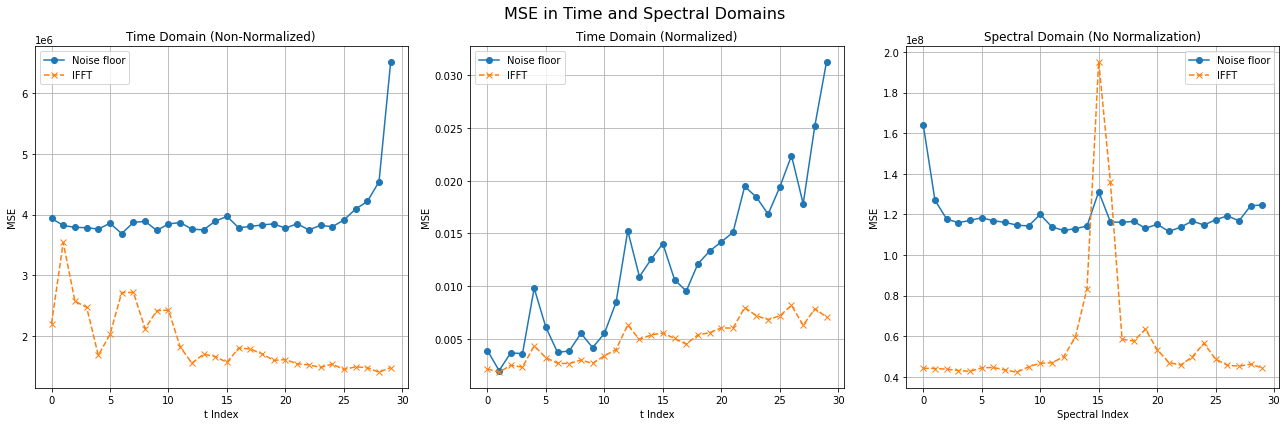

==== Model Output vs Ground Truth ====
Total MSE in image domain: 1978863.3114839261
Normalized Total MSE in image domain: 0.005977655694632373
Total MSE in spectral domain: 59365899.344517775

==== Model Input vs Ground Truth ====
Total MSE in image domain: 953525.8377482356
Normalized Total MSE in image domain: 0.0024659080952735397
Total MSE in spectral domain: 28605775.13244706


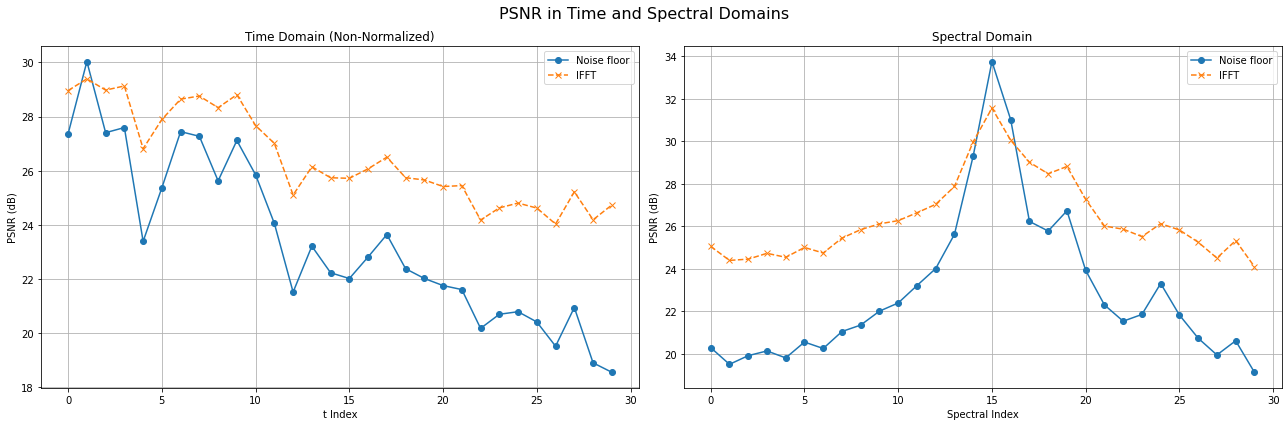

==== Model Output vs. Ground Truth ====
Average PSNR in image domain:    23.391987553295724
Average PSNR in frequency domain: 22.93057646269399

==== Model Input vs. Ground Truth ====
Average PSNR in image domain:    26.47654558502746
Average PSNR in frequency domain: 26.387090856913172


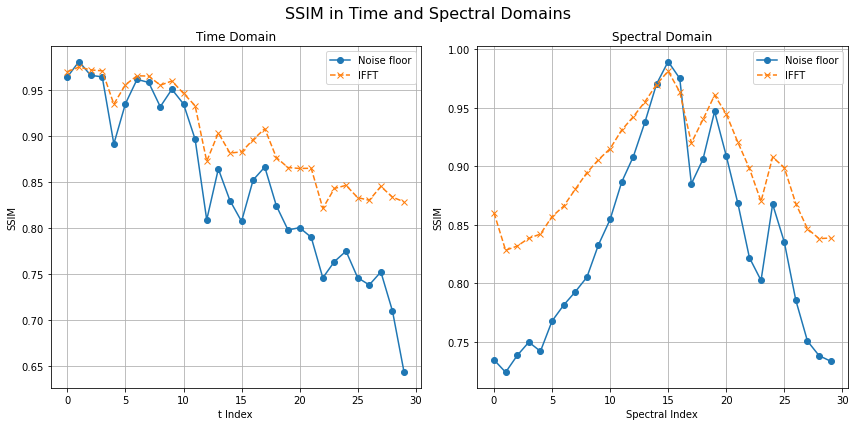

==== Model Output vs. Ground Truth ====
Average SSIM in image domain:    0.8481743369498033
Average SSIM in frequency domain: 0.8347511472507282

==== Model Input vs. Ground Truth ====
Average SSIM in image domain:    0.8997893872099153
Average SSIM in frequency domain: 0.897184186023035


In [8]:
Patient = 1
label = "Noise floor"

_, _, norm_values_test = normalize_data_per_image_new(ground_truth_trancuated[..., Patient], Undersampled_Data_trancuated[..., Patient])

plot_general_statistics(ground_truth_trancuated_2[...,Patient], Undersampled_Data_trancuated[...,Patient], ground_truth_trancuated[...,Patient], trancuate_t, norm_values_test, label)
plot_general_statistics_PSNR(ground_truth_trancuated_2[...,Patient], Undersampled_Data_trancuated[...,Patient], ground_truth_trancuated[...,Patient], trancuate_t, norm_values_test, label)
plot_general_statistics_SSIM(ground_truth_trancuated_2[...,Patient], Undersampled_Data_trancuated[...,Patient], ground_truth_trancuated[...,Patient], trancuate_t, norm_values_test, label)

/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)
../scripts/output_statistics.py:279: RuntimeWarning: invalid value encountered in double_scalars
  return calculate_rmse(pred, gt) / (gt.max() - gt.min())


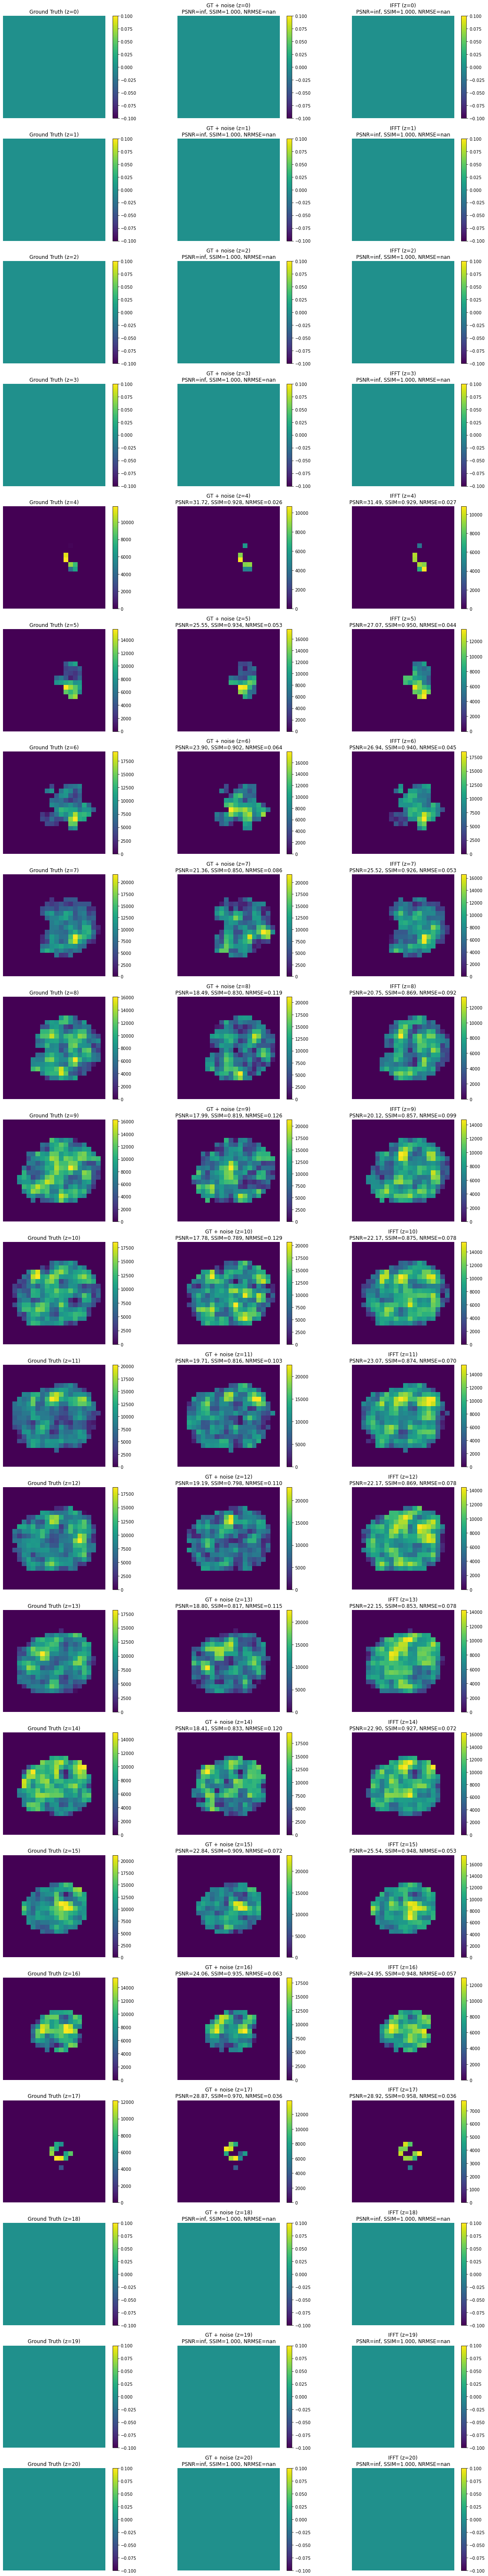

In [9]:
Patient = 4
label = "GT + noise"

domain = "time"

t = 4
T = 7

comparison_Plot_3D_vs_Ifft(ground_truth_trancuated_2[...,Patient], ground_truth_trancuated[...,Patient], Undersampled_Data_trancuated[...,Patient], t, T, domain=domain, label = label)